## Housing Market Analysis

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

# Unzipping the file
with zipfile.ZipFile('Housing_price.zip', 'r') as zip_ref:
    zip_ref.extractall('Housing_price')

# Get list of all files in the extracted folder
file_list = os.listdir('Housing_price')

# Load the first CSV file into a DataFrame
csv_file = [file for file in file_list if file.endswith('.csv')][0]
df = pd.read_csv(f'Housing_price/{csv_file}')

# Display the first few rows to inspect the data
print(df.head())

   SquareFeet  Bedrooms  Bathrooms Neighborhood  YearBuilt          Price
0        2126         4          1        Rural       1969  215355.283618
1        2459         3          2        Rural       1980  195014.221626
2        1860         2          1       Suburb       1970  306891.012076
3        2294         2          1        Urban       1996  206786.787153
4        2130         5          2       Suburb       2001  272436.239065


In [6]:
#  Initial Data Exploration
# Check the basic information and data types of each column
print("\nData Types and Non-Null Counts:\n")
print(df.info())

# Check for missing values
print("\nMissing Values:\n")
print(df.isnull().sum())

# View basic statistics of numerical columns
print("\nSummary Statistics for Numerical Columns:\n")
print(df.describe())

# Display unique values in categorical columns
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())

# Check for duplicate rows
duplicates = df[df.duplicated()]
print(f"\nNumber of duplicate rows: {len(duplicates)}")

# Check if any rows are duplicated based on an identifier (if there is one like 'House ID' or similar)
if 'House ID' in df.columns:
    house_id_duplicates = df[df['House ID'].duplicated()]
    print(f"\nNumber of duplicate House IDs: {len(house_id_duplicates)}")


Data Types and Non-Null Counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB
None

Missing Values:

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

Summary Statistics for Numerical Columns:

         SquareFeet      Bedrooms     Bathrooms     YearBuilt          Price
count  50000.000000  50000.000000  50000.000000  50000.000000   50000.000000
mean    2006.374680      3.498700      1.995420   1985.404420  224827.325151
std      575.513241      1.116326

In [8]:
# Clean Data

# Filter out rows where 'Price' is negative
df = df[df['Price'] > 0]
print(f"\nNumber of rows after removing negative prices: {len(df)}")


Number of rows after removing negative prices: 49978


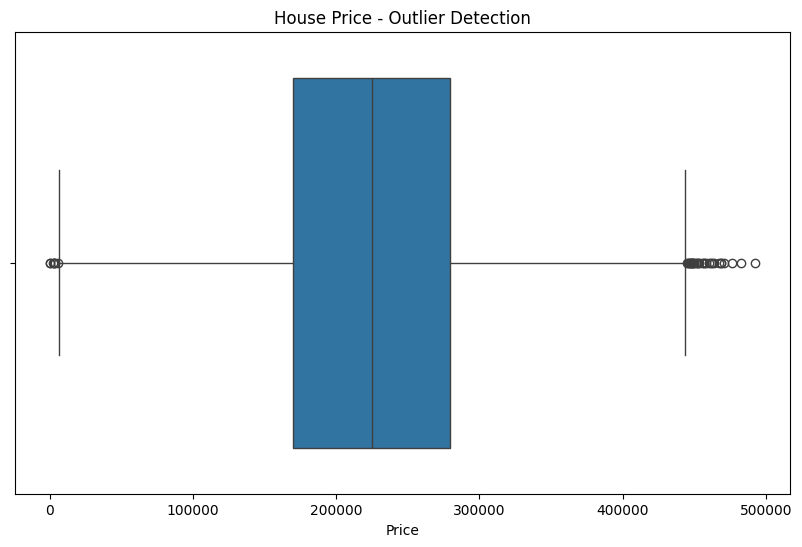

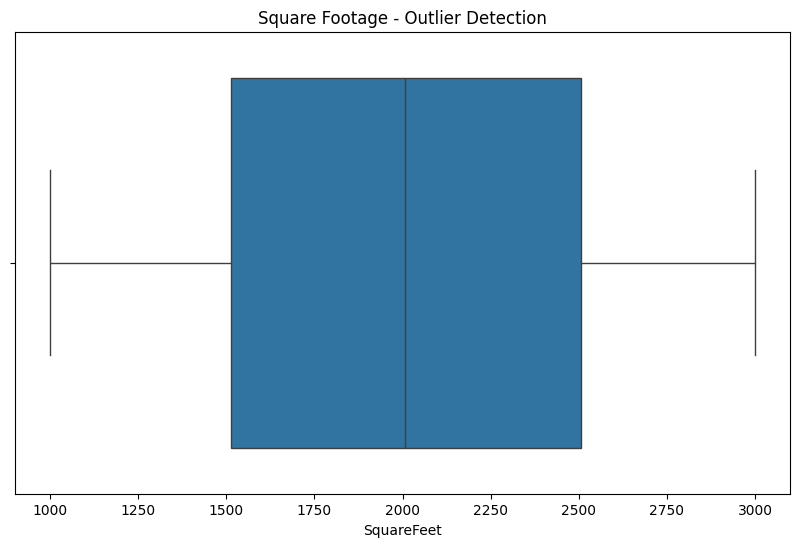

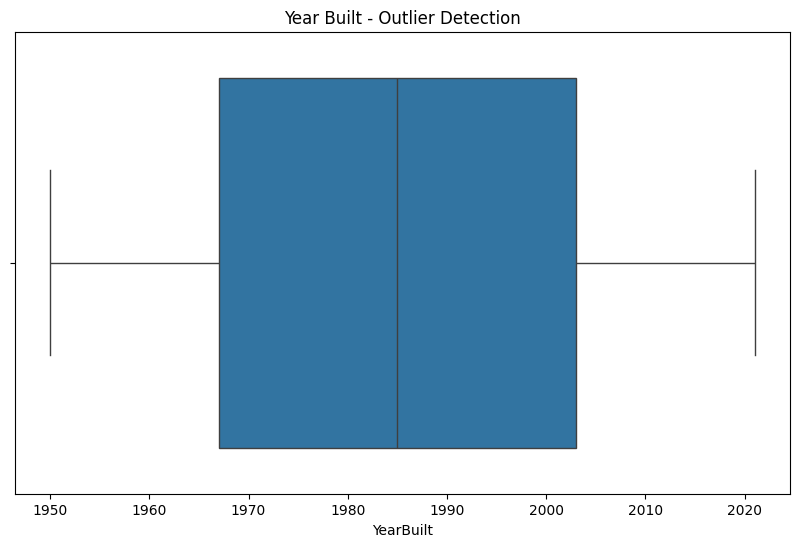

In [10]:
# Check for Outliers

# Boxplot to detect outliers in 'Price'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price'])
plt.title('House Price - Outlier Detection')
plt.show()

# Boxplot to detect outliers in 'SquareFeet'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['SquareFeet'])
plt.title('Square Footage - Outlier Detection')
plt.show()

# Boxplot to detect outliers in 'YearBuilt'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['YearBuilt'])
plt.title('Year Built - Outlier Detection')
plt.show()

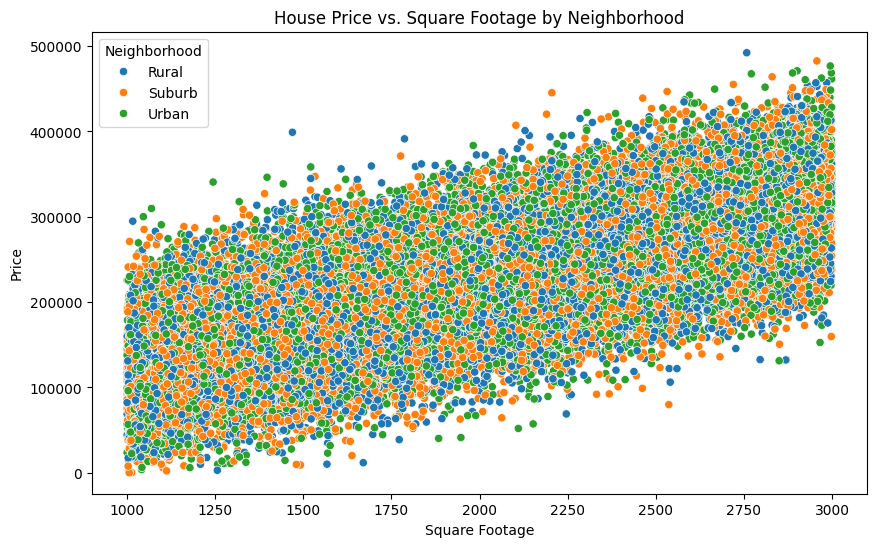

In [12]:
# EDA and Visualizations

plt.figure(figsize=(10, 6))
sns.scatterplot(x='SquareFeet', y='Price', hue='Neighborhood', data=df)
plt.xlabel('Square Footage')
plt.ylabel('Price')
plt.title('House Price vs. Square Footage by Neighborhood')
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_6472\2705287535.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Neighborhood', y='Price', data=avg_price_neighborhood, palette='viridis')


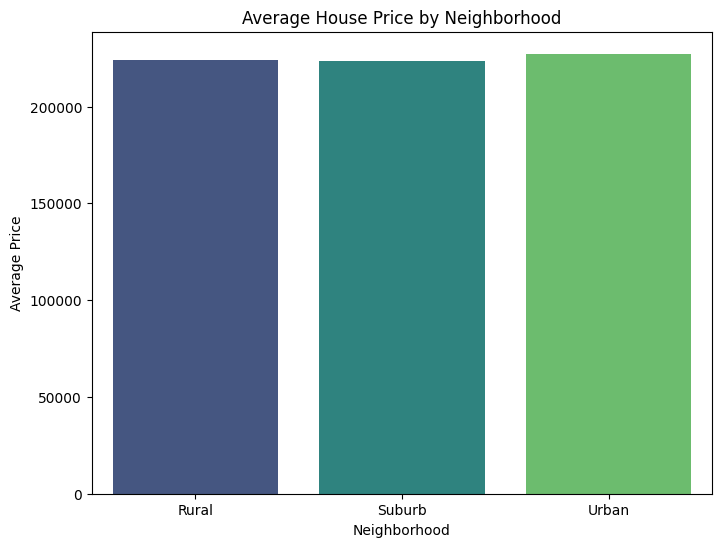

In [14]:
avg_price_neighborhood = df.groupby('Neighborhood')['Price'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Neighborhood', y='Price', data=avg_price_neighborhood, palette='viridis')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.title('Average House Price by Neighborhood')
plt.show()

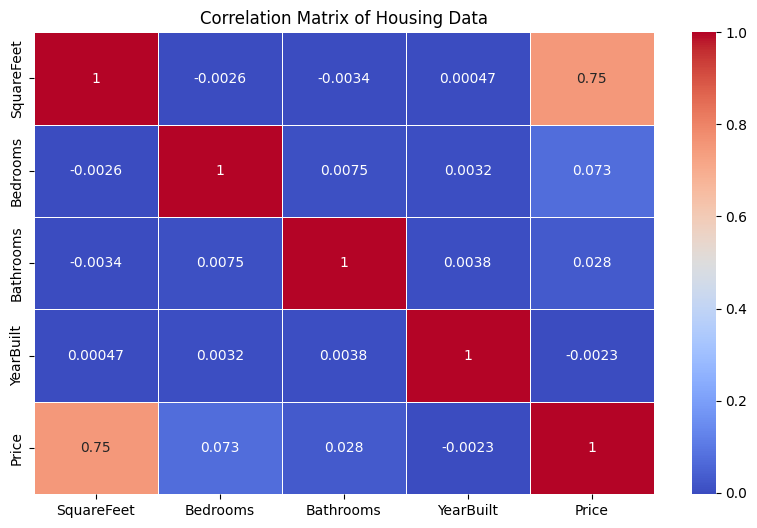

In [16]:
# Calculate the correlation matrix for only the numerical columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Housing Data')
plt.show()

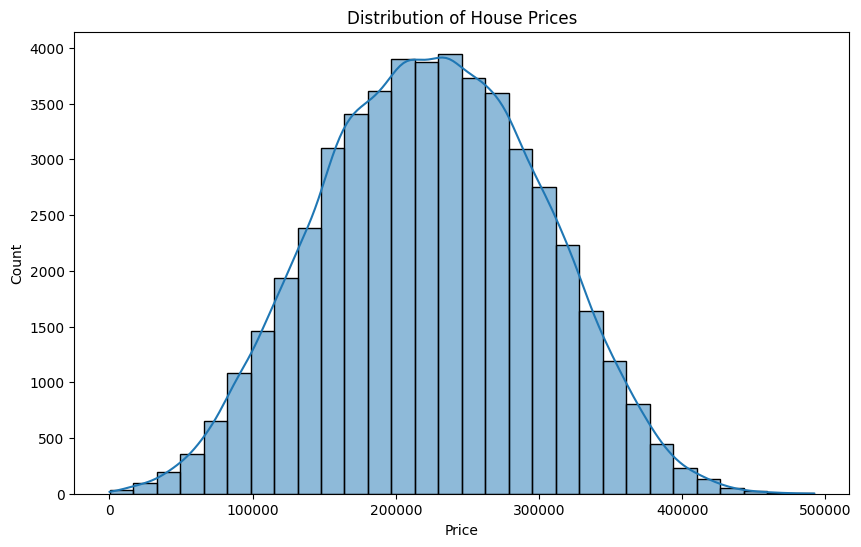

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.xlabel('Price')
plt.title('Distribution of House Prices')
plt.show()